Para acceder a los datos ir al siguiente enlace: https://drive.google.com/drive/folders/1SVHJ6vpchu8YqVvCF6Y4IrAjuVygBmGC?usp=sharing 

# Librerias vector

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import numpy as np
import pandas as pd
import mapclassify as mc
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Uso de la tierra

## Coberturas de la tierra

Se utiliza como insumo: Cobertura de la tierra 100K Periodo 2020 limite administrativo https://e436.short.gy/CobTie2020 

### Coberturas de la tierra en el área del proyecto

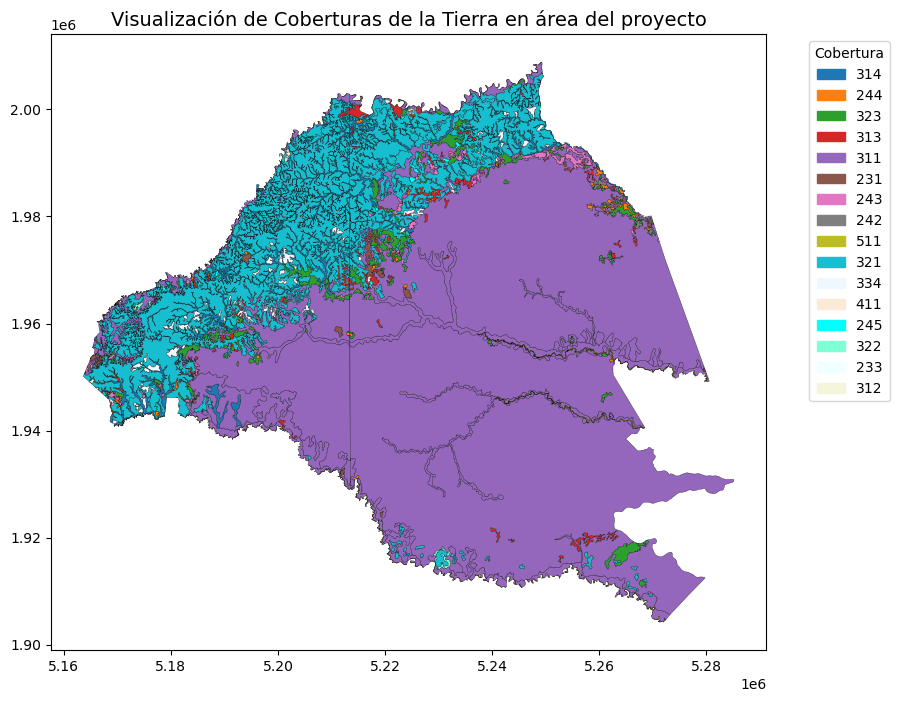

In [87]:
def visualize_land_cover(file_path ="Data\\Coberturas_project_area.shp", column_name='nivel_3'):
    # Cargar la capa geoespacial
    gdf = gpd.read_file(file_path)
    
    # Verificar si la columna existe
    if column_name not in gdf.columns:
        raise ValueError(f"La columna '{column_name}' no existe en el archivo.")
    
    # Obtener valores únicos de cobertura
    unique_covers = gdf[column_name].unique()
    
    # Asignar colores distintos a cada categoría
    colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    color_map = {cover: colors[i % len(colors)] for i, cover in enumerate(unique_covers)}
    
    # Crear la visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    legend_patches = []
    for cover, color in color_map.items():
        gdf[gdf[column_name] == cover].plot(ax=ax, color=color, edgecolor='black', linewidth=0.2)
        legend_patches.append(mpatches.Patch(color=color, label=cover))
    
    # Configuración del mapa
    ax.set_title("Visualización de Coberturas de la Tierra en área del proyecto", fontsize=14)
    ax.legend(handles=legend_patches, title="Cobertura", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Uso del script
visualize_land_cover()

### Coberturas de la tierra en el ROI

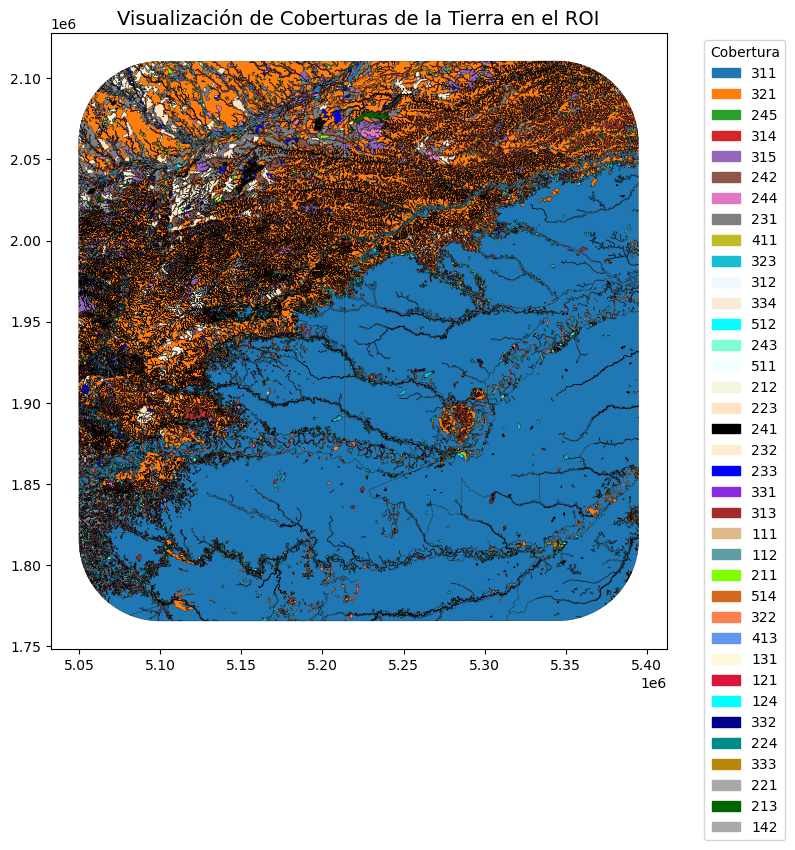

In [93]:
def visualize_land_cover(file_path ="Data\\Coberturas_ROI.shp", column_name='nivel_3'):
    # Cargar la capa geoespacial
    gdf = gpd.read_file(file_path)
    
    # Verificar si la columna existe
    if column_name not in gdf.columns:
        raise ValueError(f"La columna '{column_name}' no existe en el archivo.")
    
    # Obtener valores únicos de cobertura
    unique_covers = gdf[column_name].unique()
    
    # Asignar colores distintos a cada categoría
    colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    color_map = {cover: colors[i % len(colors)] for i, cover in enumerate(unique_covers)}
    
    # Crear la visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    legend_patches = []
    for cover, color in color_map.items():
        gdf[gdf[column_name] == cover].plot(ax=ax, color=color, edgecolor='black', linewidth=0.2)
        legend_patches.append(mpatches.Patch(color=color, label=cover))
    
    # Configuración del mapa
    ax.set_title("Visualización de Coberturas de la Tierra en el ROI", fontsize=14)
    ax.legend(handles=legend_patches, title="Cobertura", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Uso del script
visualize_land_cover()

# Conexiones de transporte e infraestructura humana

## Vías

Se utiliza como insumo: Base de datos vectorial básica. Colombia. Escala 1:100.000. Año 2022 https://www.colombiaenmapas.gov.co/?e=-82.66306750976614,-1.472155764324179,-65.83201282227061,11.52294072264956,4686&b=igac&u=0&t=23&servicio=205 

### Densidad de vías para área del proyecto

A continuación se desarrolla un script para saber cuál es la densidad de vías, definida en m2 sobre km2, dentro del área del proyecto establecida, en este caso el Resguardo Indígena Alto Unuma.

C:\Users\Andres Wilches\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Andres Wilches\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Límites de los Natural Breaks: [  0.          76.55056354 133.38024989 211.43951752 326.45028819]


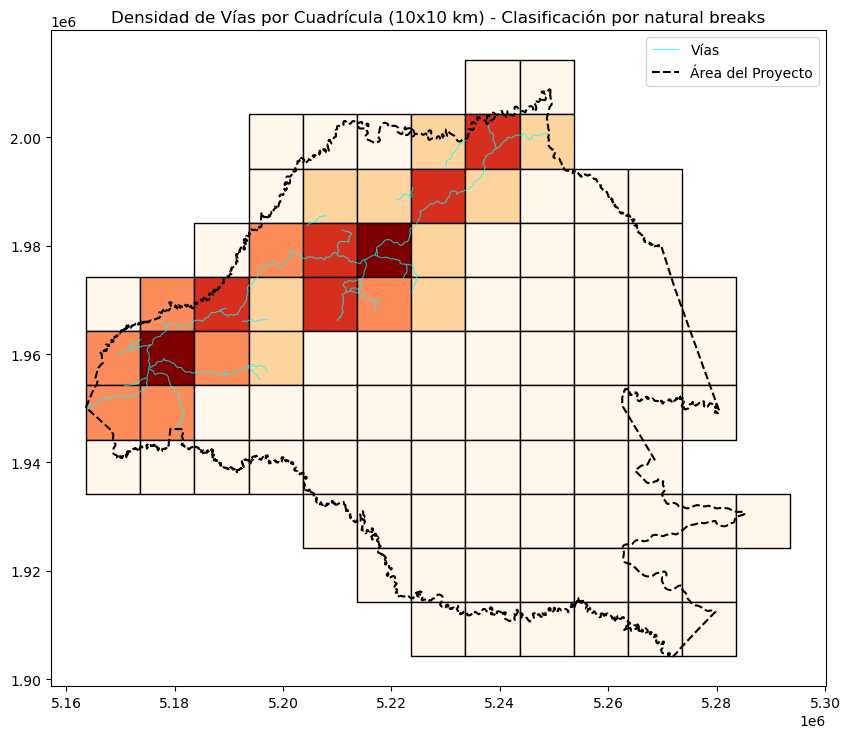

In [9]:
# Cargar datos
# Se cargan los archivos de shapefile que contienen el área del proyecto y las vías
project_area = gpd.read_file("Data\\RI_UNUMA_Project.shp")
vias = gpd.read_file("Data\\Vias_project_area.shp")

# ---- Definir límites del área del proyecto ----
# Se extraen los límites de la extensión del área del proyecto y el sistema de referencia (CRS)
bounds = project_area.total_bounds
crs = project_area.crs  # Sistema de referencia

# ---- Creación de la cuadrícula ----
# Se define la resolución de la cuadrícula en 10 km (10,000 metros)
res = 10000
xmin, ymin, xmax, ymax = bounds

# Se generan las coordenadas de las columnas y filas de la cuadrícula
cols = np.arange(np.floor(xmin), np.ceil(xmax + res), res)
rows = np.arange(np.floor(ymin), np.ceil(ymax + res), res)[::-1]  # Invertir filas para orden cartesiano

# Se crean polígonos cuadrados para cada celda de la cuadrícula
polygons = [
    shapely.Polygon([(x, y), (x + res, y), (x + res, y - res), (x, y - res)])
    for x in cols for y in rows
]

# Se genera un GeoDataFrame con la cuadrícula creada
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

# ---- Filtrado de la cuadrícula ----
# Se filtran las celdas que intersectan con el área del proyecto
grid = grid[grid.intersects(project_area.union_all())]
grid['id'] = grid.index  # Se asigna un ID único a cada celda

# ---- Recorte de las vías dentro de cada celda ----
# Se intersectan las vías con la cuadrícula para obtener solo las que están dentro de cada celda
vias_clip = gpd.overlay(vias, grid, how='intersection')

# ---- Cálculo de la longitud de vías por celda ----
# Se calcula la longitud de las vías en metros dentro de cada celda
vias_clip["longitud_via_m"] = vias_clip.geometry.length

# Se agrupa la información sumando la longitud total de vías por celda
vias_grid = vias_clip.groupby("id")["longitud_via_m"].sum().reset_index()

# Se unen los datos de longitud de vías a la cuadrícula original
grid = grid.merge(vias_grid, on="id", how="left").fillna(0)

# ---- Cálculo de la densidad de vías ----
# Se calcula el área de cada celda en km² (10x10 km = 100 km² por celda)
grid["area_km2"] = (res / 1000) ** 2  # Convertir metros cuadrados a kilómetros cuadrados

# Se calcula la densidad de vías en cada celda (longitud de vías en metros por km²)
grid["densidad_vias"] = grid["longitud_via_m"] / grid["area_km2"]

# ---- Clasificación mediante Natural Breaks ----
# Se aplican los Natural Breaks para segmentar los valores de densidad en 5 categorías
nb = mc.NaturalBreaks(grid["densidad_vias"], k=5)
print("Límites de los Natural Breaks:", nb.bins)

# ---- Visualización de los resultados ----
fig, ax = plt.subplots(figsize=(10, 10))

# Se plotea la cuadrícula con la clasificación por densidad de vías
grid.plot(column="densidad_vias", cmap="OrRd", edgecolor="black",
          scheme="NaturalBreaks", k=5, legend=True, ax=ax,
          legend_kwds={'fmt': "{:.2f}"})

# Se plotean las vías y el área del proyecto
vias.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Vías")
project_area.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="Área del Proyecto")

# Ajustes finales del gráfico
ax.set_title("Densidad de Vías por Cuadrícula (10x10 km) - Clasificación por natural breaks")
ax.legend()
plt.show()

Este script calcula la media y la desviación estándar de la densidad de vías dentro de la cuadrícula y utiliza estos valores para definir límites de clasificación personalizados. Estos límites permiten una segmentación basada en la distribución estadística de los datos. La media representa el valor promedio de densidad de vías en las celdas, mientras que la desviación estándar indica la dispersión de los valores en relación con la media. Este método es útil para clasificar los datos en rangos que reflejan la variabilidad real de la distribución.

Media de densidad de vías: 29.668134470649555
Desviación estándar de densidad de vías: 64.71975518280034
Límites Basados en Media y Desviación Estándar: [0, 29.668134470649555, 94.38788965344989, 159.10764483625024, 326.45028819115976]


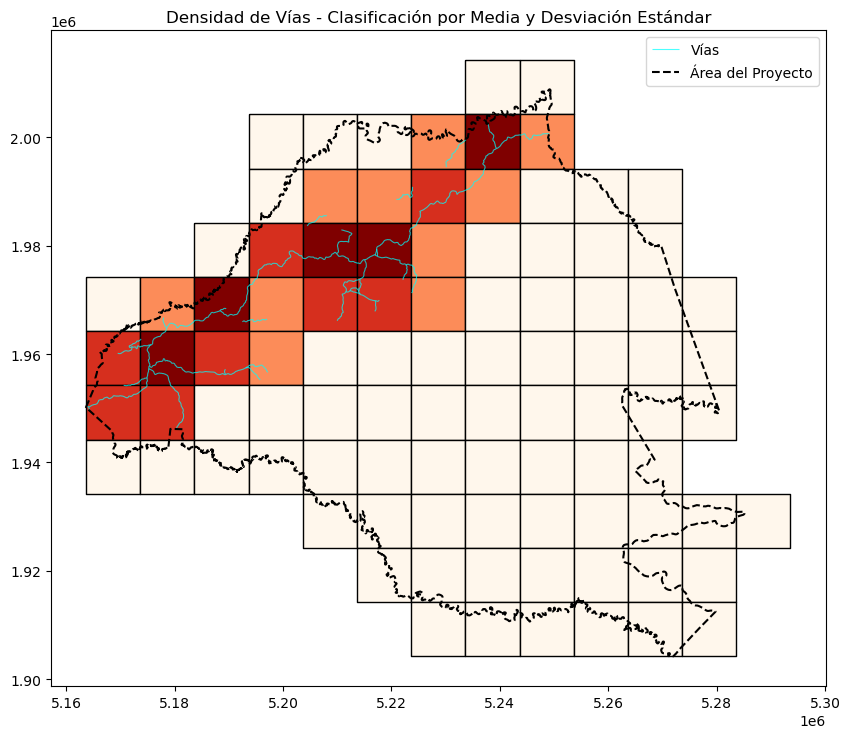

In [32]:
# ---- Cálculo de Media y Desviación Estándar ----
# Se calcula la media (promedio) de la densidad de vías y su desviación estándar.
mean_density = grid["densidad_vias"].mean()
std_density = grid["densidad_vias"].std()

# Se imprimen los valores calculados
print("Media de densidad de vías:", mean_density)
print("Desviación estándar de densidad de vías:", std_density)

# ---- Definición de límites ----
# Se definen los límites basados en la media y la desviación estándar:
# - Media - 1σ: un valor por debajo del promedio
# - Media: punto central de la distribución
# - Media + 1σ, +2σ, +3σ: valores crecientes que representan desviaciones mayores
bins = [0, mean_density - std_density, mean_density, mean_density + std_density, mean_density + 2 * std_density, grid["densidad_vias"].max()]

# Se eliminan valores negativos para evitar clasificaciones incorrectas
bins = [b for b in bins if b >= 0]

print("Límites Basados en Media y Desviación Estándar:", bins)

# ---- Visualización de Resultados ----
# Se genera un gráfico que muestra la densidad de vías usando la clasificación definida por los límites
fig, ax = plt.subplots(figsize=(10, 10))

grid.plot(column="densidad_vias", cmap="OrRd", edgecolor="black",
          scheme="UserDefined", classification_kwds={"bins": bins},
          legend=True, ax=ax, legend_kwds={'fmt': "{:.2f}"})

# Se plotean las vías y el área del proyecto
vias.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Vías")
project_area.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="Área del Proyecto")

# Configuración final del gráfico
ax.set_title("Densidad de Vías - Clasificación por Media y Desviación Estándar")
ax.legend()
plt.show()

### Densidad de vías para el ROI

Dado que el objetivo del proyecto, es encontrar una zona similar al área de estudio, para establecer una línea base de un proyecto de carbono, se delimita un ROI (Region Of Interest) sobre el cual, se realiza el mismo procedimiento anteriormente descrito, pero esta vez se tiene en cuenta en la visualización los límites definidos por medio de la media y la desviación estándar, para encontrar efectivamente las zonas espaciales que tengan mayor similitud a la situación en el área del proyecto.

📌 Valor máximo de densidad de vías: 1875.92 metros/km²


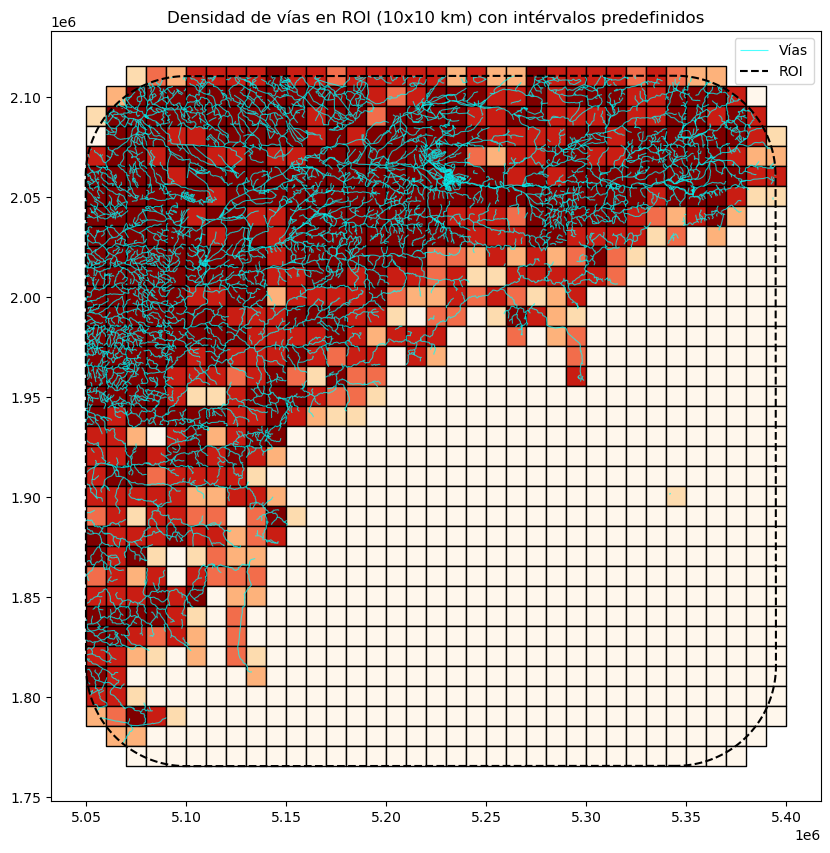

In [30]:
# ---- Carga de Datos ----
# Se cargan los archivos shapefile que contienen la región de interés (ROI) y las vías en la zona
ROI = gpd.read_file("Data\\ROI_2.shp")
vias_roi = gpd.read_file("Data\\Vias_roi.shp")

# ---- Definir Límites del Área de Interés ----
# Se extraen los límites espaciales y el sistema de referencia (CRS)
bounds_roi = ROI.total_bounds
crs = ROI.crs  # Sistema de referencia

# ---- Creación de la Cuadrícula ----
# Se define la resolución de la cuadrícula en 10 km (10,000 metros)
res = 10000
xmin, ymin, xmax, ymax = bounds_roi

# Se generan las coordenadas de columnas y filas para la cuadrícula
cols = np.arange(np.floor(xmin), np.ceil(xmax + res), res)
rows = np.arange(np.floor(ymin), np.ceil(ymax + res), res)[::-1]  # Invertir filas para orden cartesiano

# Se crean polígonos cuadrados para cada celda de la cuadrícula
polygons = [
    shapely.Polygon([(x, y), (x + res, y), (x + res, y - res), (x, y - res)])
    for x in cols for y in rows
]

# Se genera un GeoDataFrame con la cuadrícula creada
grid_roi = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

# ---- Filtrado de la cuadrícula ----
# Se filtran las celdas que intersectan con el área de interés
grid_roi = grid_roi[grid_roi.intersects(ROI.union_all())]
grid_roi['id'] = grid_roi.index # Se asigna un ID único a cada celda

# ---- Recorte de vías dentro de cada celda ----
# Se intersectan las vías con la cuadrícula para obtener solo las que están dentro de cada celda
vias_clip_roi = gpd.overlay(vias_roi, grid_roi, how='intersection')

# ---- Cálculo de la longitud de vías por celda ----
# Se calcula la longitud total de vías dentro de cada celda
vias_clip_roi["longitud_via_m"] = vias_clip_roi.geometry.length
vias_grid_roi = vias_clip_roi.groupby("id")["longitud_via_m"].sum().reset_index()

# Se unen los datos de longitud de vías a la cuadrícula original
grid_roi = grid_roi.merge(vias_grid_roi, on="id", how="left").fillna(0)

# ---- Cálculo de la densidad de vías ----
# Se calcula el área de cada celda en km² (10x10 km = 100 km² por celda)
grid_roi["area_km2"] = (res / 1000) ** 2  # Convertir metros cuadrados a kilómetros cuadrados

# Calcular la densidad de vías (longitud de vías en metros por km²)
grid_roi["densidad_vias"] = grid_roi["longitud_via_m"] / grid_roi["area_km2"]

# ---- Obtener y mostrar el máximo valor de densidad de vías ----
max_density = grid_roi["densidad_vias"].max()
print(f"📌 Valor máximo de densidad de vías: {max_density:.2f} metros/km²")

# ---- Definición de límites de clasificación ----
# Se establecen los límites de clasificación utilizando intervalos definidos previamente
natural_breaks_bins = [0, 29.668134470649555, 94.38788965344989, 159.10764483625024, 326.45028819115976, 1876]

# ---- Visualización de Resultados ----
fig, ax = plt.subplots(figsize=(10, 10))

# Se plotea la cuadrícula con la clasificación definida
grid_roi.plot(column="densidad_vias", cmap="OrRd", edgecolor="black",
              legend=True, ax=ax, 
              scheme="UserDefined", classification_kwds={"bins": natural_breaks_bins},
              legend_kwds={'fmt': "{:.2f}"})

# Se plotean las vías y el área del proyecto
vias_roi.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Vías")
ROI.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="ROI")

# Configuración final del gráfico
ax.set_title("Densidad de vías en ROI (10x10 km) con intérvalos predefinidos")
ax.legend()
plt.show()

### Clasificación

Una vez se han definido los intervalos, se clasifica la densidad de vías del ROI según los límites definidos para el área del proyecto. Se asigna una clase a cada celda en función de la densidad de vías, con valores del 0 al 4.

In [36]:
# ---- Copia del GeoDataFrame ----
# Se crea una copia del GeoDataFrame de la cuadrícula para trabajar con la clasificación
grid_class = grid_roi.copy()

# ---- Definición de límites y clases ----
# Se establecen los límites de densidad de vías y sus respectivas categorías (de 0 a 4)
bins = [0, 29.668134470649555, 94.38788965344989, 159.10764483625024, 326.45028819115976, 1876]
values = [4, 3, 2, 1, 0]

# ---- Asignación de clases ----
# Se clasifica la densidad de vías en la cuadrícula utilizando los límites definidos
grid_class["clase_densidad"] = pd.cut(grid_class["densidad_vias"], bins=bins, labels=values, include_lowest=True)

# Se convierte la columna de clasificación a enteros
grid_class["clase_densidad"] = grid_class["clase_densidad"].astype(int)

# Verificar los valores generados
print("📌 Distribución de la clasificación:")
print(grid_class["clase_densidad"].value_counts().sort_index())

📌 Distribución de la clasificación:
clase_densidad
0    297
1    185
2     47
3     44
4    638
Name: count, dtype: int64


Una vez se ha definido la clase de densidad, se visualizan los resultados de la densidad de vías por cuadrícula.

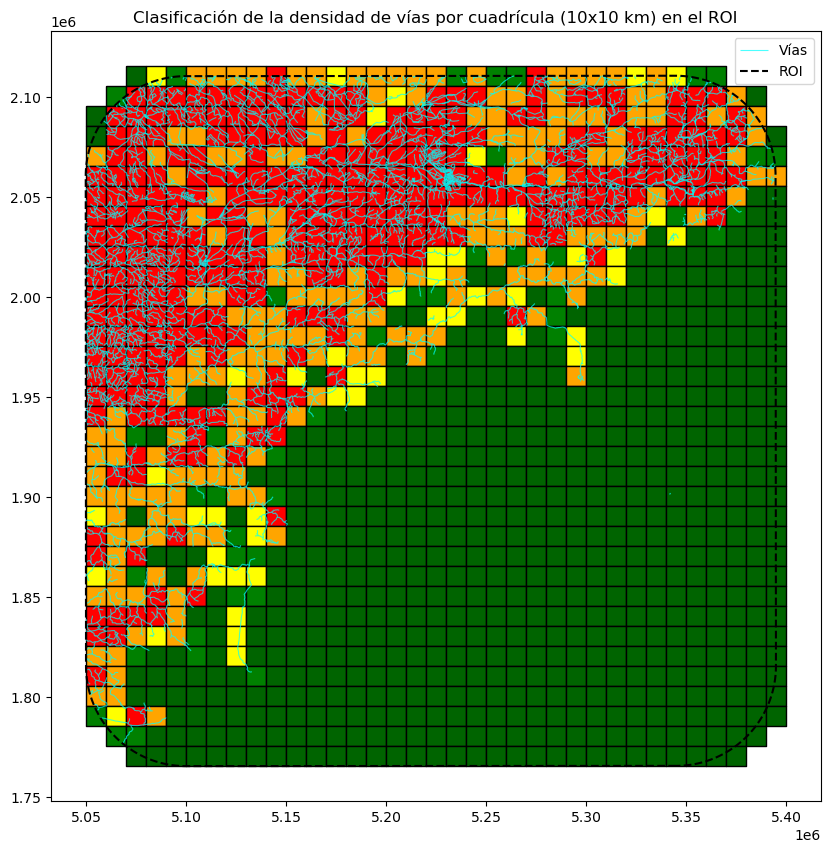

In [39]:
# ---- Definición de la paleta de colores ----
# Se asocia cada clase de densidad con un color específico para facilitar la interpretación visual
color_map = {
    4: "darkgreen",  # Menor densidad
    3: "green",
    2: "yellow",
    1: "orange",
    0: "red"  # Mayor densidad
}

# Crear la visualización
fig, ax = plt.subplots(figsize=(10, 10))

# Se aplica la paleta de colores definida a la cuadrícula
grid_class.plot(color=grid_class["clase_densidad"].map(color_map), edgecolor="black", ax=ax)

# Se plotean las vías y el ROI
vias_roi.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Vías")
ROI.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="ROI")

# Configuración del gráfico
ax.set_title("Clasificación de la densidad de vías por cuadrícula (10x10 km) en el ROI")
ax.legend()
plt.show()

## Drenajes dobles

Se utiliza como insumo: Base de datos vectorial básica. Colombia. Escala 1:100.000. Año 2022 https://www.colombiaenmapas.gov.co/?e=-82.66306750976614,-1.472155764324179,-65.83201282227061,11.52294072264956,4686&b=igac&u=0&t=23&servicio=205

### Densidad de drenajes dobles para área del proyecto

A continuación se desarrolla un script para saber cuál es la densidad de drenajes dobles, definida en km2 sobre km2, dentro del área del proyecto establecida, en este caso el Resguardo Indígena Alto Unuma.

C:\Users\Andres Wilches\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Andres Wilches\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Límites de los Natural Breaks: [ 463.70016315 1386.81251071 2460.24280788 5382.219526   7328.89618087]


C:\Users\Andres Wilches\AppData\Local\Temp\ipykernel_14180\1091697217.py:74: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


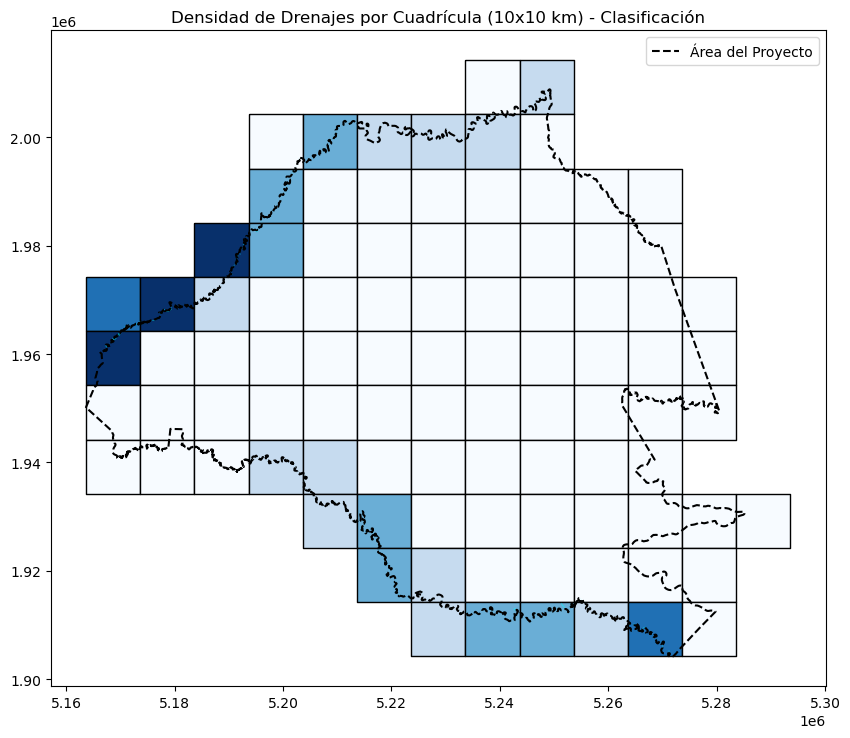

In [13]:
# ---- Carga de datos ----
# Se cargan los archivos shapefile que contienen el área del proyecto y los drenajes
drenajes = gpd.read_file("Data/Drenaje_Doble_project_area.shp")

# ---- Definir límites del área del proyecto ----
# Se extraen los límites espaciales y el sistema de referencia (CRS)
bounds = project_area.total_bounds  # [xmin, ymin, xmax, ymax]
crs = project_area.crs  # Sistema de referencia

# ---- Creación de la cuadrícula ----
# Se define la resolución de la cuadrícula en 10 km (10,000 metros)
res = 10000
xmin, ymin, xmax, ymax = bounds

# Se generan las coordenadas de columnas y filas para la cuadrícula
cols = np.arange(np.floor(xmin), np.ceil(xmax + res), res)
rows = np.arange(np.floor(ymin), np.ceil(ymax + res), res)[::-1]  # Invertir filas para orden cartesiano

# Se crean polígonos cuadrados para cada celda de la cuadrícula
polygons = [
    shapely.Polygon([(x, y), (x + res, y), (x + res, y - res), (x, y - res)])
    for x in cols for y in rows
]

# Se genera un GeoDataFrame con la cuadrícula creada
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

# ---- Filtrado de la Cuadrícula ----
# Se filtran las celdas que intersectan con el área del proyecto
grid = grid[grid.intersects(project_area.union_all())]
grid['id'] = grid.index  # Se asigna un ID único a cada celda

# ---- Recorte de los Drenajes Dentro de Cada Celda ----
# Se intersectan los drenajes con la cuadrícula para obtener solo las partes dentro de cada celda
drenajes_clip = gpd.overlay(drenajes, grid, how='intersection')

# ---- Cálculo del Área de Drenajes por Celda ----
# Se calcula el área total de drenaje dentro de cada celda
drenajes_clip["area_drenaje_m2"] = drenajes_clip.geometry.area  # Área en metros cuadrados

drenajes_grid = drenajes_clip.groupby("id")["area_drenaje_m2"].sum().reset_index()

# Se unen los datos de área de drenajes a la cuadrícula original
grid = grid.merge(drenajes_grid, on="id", how="left").fillna(0)

# ---- Cálculo de la Densidad de Drenajes ----
# Se calcula el área de cada celda en km² (10x10 km = 100 km² por celda)
grid["area_km2"] = (res / 1000) ** 2

# Se calcula la densidad de drenajes en cada celda
grid["densidad_drenajes"] = grid["area_drenaje_m2"] / grid["area_km2"]

# ---- Clasificación mediante Natural Breaks ----
# Se aplican Natural Breaks para segmentar los valores de densidad en 5 categorías
nb = mc.NaturalBreaks(grid["densidad_drenajes"], k=5)
print("Límites de los Natural Breaks:", nb.bins)

# ---- Visualización de Resultados ----
fig, ax = plt.subplots(figsize=(10, 10))

# Se plotea la cuadrícula con la clasificación definida por densidad de drenajes
grid.plot(column="densidad_drenajes", cmap="Blues", edgecolor="black",
          scheme="NaturalBreaks", k=5, legend=True, ax=ax,
          legend_kwds={'fmt': "{:.2f}"})

# Se plotean los drenajes en color cian
drenajes.plot(ax=ax, color="cyan", alpha=0.7, label="Drenajes")

# Se plotea el área del proyecto con un contorno negro
project_area.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="Área del Proyecto")

# ---- Configuración Final del Gráfico ----
ax.set_title("Densidad de Drenajes por Cuadrícula (10x10 km) - Clasificación")
ax.legend()
plt.show()

Este script calcula la media y la desviación estándar de la densidad de drenajes dentro de la cuadrícula y utiliza estos valores para definir límites de clasificación personalizados. Estos límites permiten una segmentación basada en la distribución estadística de los datos. La media representa el valor promedio de densidad de drenajes en las celdas, mientras que la desviación estándar indica la dispersión de los valores en relación con la media. Este método es útil para clasificar los datos en rangos que reflejan la variabilidad real de la distribución.

Media de densidad de drenajes: 590.2527587718203
Desviación estándar de densidad de drenajes: 1457.1998016640575
Límites Basados en Media y Desviación Estándar: [0, 590.2527587718203, 2047.4525604358778, 3504.652362099935, 7328.896180867518]


C:\Users\Andres Wilches\AppData\Local\Temp\ipykernel_14180\1570223433.py:39: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


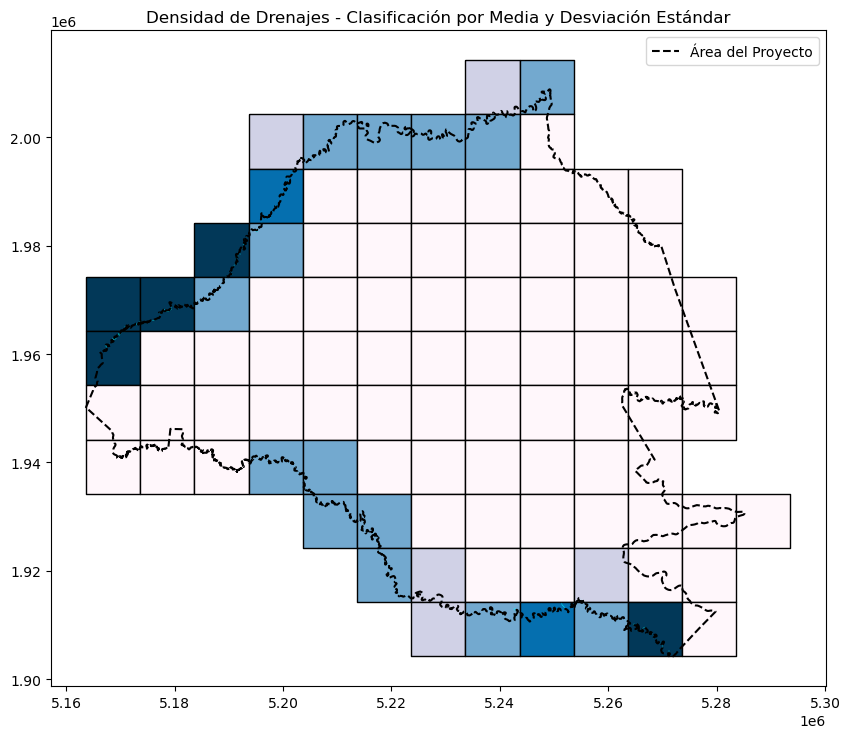

In [16]:
# ---- Cálculo de Media y Desviación Estándar ----
# Se calcula la media (promedio) de la densidad de drenajes y su desviación estándar.
mean_density = grid["densidad_drenajes"].mean()
std_density = grid["densidad_drenajes"].std()

# Se imprimen los valores calculados
print("Media de densidad de drenajes:", mean_density)
print("Desviación estándar de densidad de drenajes:", std_density)

# ---- Definición de Límites Manuales ----
# Se definen los límites basados en la media y la desviación estándar:
# - Media - 1σ: Un valor por debajo del promedio
# - Media: Punto central de la distribución
# - Media + 1σ, +2σ, +3σ: Valores crecientes que representan desviaciones mayores
bins = [0, mean_density - std_density, mean_density, mean_density + std_density, mean_density + 2 * std_density, grid["densidad_drenajes"].max()]

# Se eliminan valores negativos para evitar clasificaciones incorrectas
bins = [b for b in bins if b >= 0]

# Se imprimen los límites definidos
print("Límites Basados en Media y Desviación Estándar:", bins)

# ---- Visualización de Resultados ----
# Se genera un gráfico que muestra la densidad de drenajes usando la clasificación definida por los límites
fig, ax = plt.subplots(figsize=(10, 10))

grid.plot(column="densidad_drenajes", cmap="PuBu", edgecolor="black",
          scheme="UserDefined", classification_kwds={"bins": bins},
          legend=True, ax=ax, legend_kwds={'fmt': "{:.2f}"})

# Se plotean los drenajes en color cian
drenajes.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Drenajes")

# Se plotea el área del proyecto con un contorno negro
project_area.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="Área del Proyecto")

# Configuración final del gráfico
ax.set_title("Densidad de Drenajes - Clasificación por Media y Desviación Estándar")
ax.legend()
plt.show()

### Densidad de drenajes dobles para ROI

Dado que el objetivo del proyecto, es encontrar una zona similar al área de estudio, para establecer una línea base de un proyecto de carbono, se delimita un ROI (Region Of Interest) sobre el cual, se realiza el mismo procedimiento anteriormente descrito, pero esta vez se tiene en cuenta en la visualización los límites definidos por medio de la media y la desviación estándar, para encontrar efectivamente las zonas espaciales que tengan mayor similitud a la situación en el área del proyecto.

📌 Valor máximo de densidad de drenajes: 127544.60 m²/km²


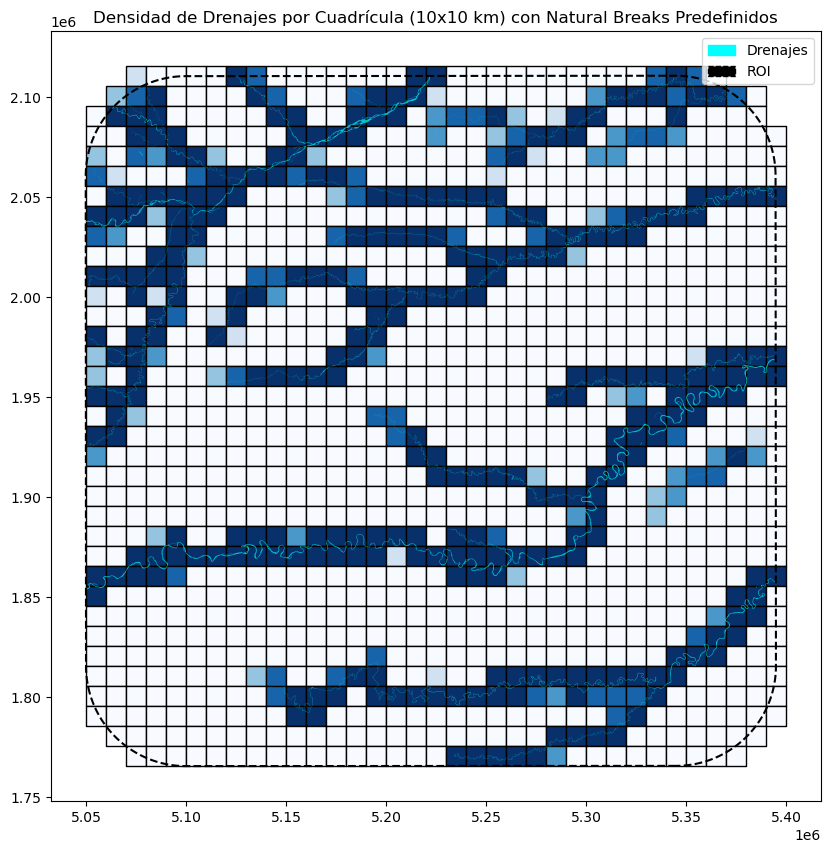

In [21]:
# ---- Carga de Datos ----
# Se cargan los archivos shapefile que contienen la región de interés (ROI) y los drenajes
ROI = gpd.read_file("Data/ROI_2.shp")
drenajes_roi = gpd.read_file("Data/Drenaje_Doble_ROI.shp")  # Reemplazo de vías por drenajes

# ---- Definir Límites del Área de Interés ----
# Se extraen los límites espaciales y el sistema de referencia (CRS)
bounds_roi = ROI.total_bounds  # [xmin, ymin, xmax, ymax]
crs = ROI.crs  # Sistema de referencia

# ---- Creación de la Cuadrícula ----
# Se define la resolución de la cuadrícula en 10 km (10,000 metros)
res = 10000
xmin, ymin, xmax, ymax = bounds_roi

# Se generan las coordenadas de columnas y filas para la cuadrícula
cols = np.arange(np.floor(xmin), np.ceil(xmax + res), res)
rows = np.arange(np.floor(ymin), np.ceil(ymax + res), res)[::-1]  # Invertir filas para orden cartesiano

# Se crean polígonos cuadrados para cada celda de la cuadrícula
polygons = [
    shapely.Polygon([(x, y), (x + res, y), (x + res, y - res), (x, y - res)])
    for x in cols for y in rows
]

# Se genera un GeoDataFrame con la cuadrícula creada
grid_roi = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

# ---- Filtrado de la Cuadrícula ----
# Se filtran las celdas que intersectan con el área de interés
grid_roi = grid_roi[grid_roi.intersects(ROI.union_all())]
grid_roi['id'] = grid_roi.index  # Se asigna un ID único a cada celda

# ---- Recorte de los Drenajes Dentro de Cada Celda ----
# Se intersectan los drenajes con la cuadrícula para obtener solo las partes dentro de cada celda
drenajes_clip_roi = gpd.overlay(drenajes_roi, grid_roi, how='intersection')

# ---- Cálculo del Área de Drenajes por Celda ----
# Se calcula el área total de drenaje dentro de cada celda
drenajes_clip_roi["area_drenaje_m2"] = drenajes_clip_roi.geometry.area  # Área en metros cuadrados

drenajes_grid_roi = drenajes_clip_roi.groupby("id")["area_drenaje_m2"].sum().reset_index()

# Se unen los datos de área de drenajes a la cuadrícula original
grid_roi = grid_roi.merge(drenajes_grid_roi, on="id", how="left").fillna(0)

# ---- Cálculo de la Densidad de Drenajes ----
# Se calcula el área de cada celda en km² (10x10 km = 100 km² por celda)
grid_roi["area_km2"] = (res / 1000) ** 2

# Se calcula la densidad de drenajes en cada celda
grid_roi["densidad_drenajes"] = grid_roi["area_drenaje_m2"] / grid_roi["area_km2"]

# ---- Obtener y Mostrar el Máximo Valor de Densidad de Drenajes ----
max_density = grid_roi["densidad_drenajes"].max()
print(f"📌 Valor máximo de densidad de drenajes: {max_density:.2f} m²/km²")

# ---- Definición de Límites de Clasificación ----
# Se establecen los límites de clasificación utilizando Natural Breaks predefinidos
natural_breaks_bins = [0, 590.2527587718203, 2047.4525604358778, 3504.652362099935, 7328.896180867518, max_density]

# ---- Visualización de Resultados ----
fig, ax = plt.subplots(figsize=(10, 10))

# Se plotea la cuadrícula con la clasificación definida por densidad de drenajes
grid_roi.plot(column="densidad_drenajes", cmap="Blues", edgecolor="black",
              legend=True, ax=ax, 
              scheme="UserDefined", classification_kwds={"bins": natural_breaks_bins},
              legend_kwds={'fmt': "{:.2f}"})

# Se plotean los drenajes en color cian
drenajes_roi.plot(ax=ax, color="cyan", alpha=0.7)

# Se plotea el área del proyecto con un contorno negro
ROI.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed")

# 🔹 Creación de la leyenda manualmente para evitar errores con PatchCollection
legend_patches = [
    mpatches.Patch(color="cyan", label="Drenajes"),
    mpatches.Patch(color="black", label="ROI", linestyle="dashed")
]

# Agregar la leyenda corregida
ax.legend(handles=legend_patches, loc="upper right")

# Configuración final del gráfico
ax.set_title("Densidad de Drenajes por Cuadrícula (10x10 km) con Natural Breaks Predefinidos")
plt.show()

### Clasificación

Una vez se han definido los intervalos, se clasifica la densidad de drenajes del ROI según los límites definidos para el área del proyecto. Se asigna una clase a cada celda en función de la densidad de drenajes, con valores del 0 al 4.

In [26]:
# ---- Copia del GeoDataFrame ----
# Se crea una copia del GeoDataFrame de la cuadrícula para trabajar con la clasificación
grid_class = grid_roi.copy()

# ---- Definición de Límites y Clases ----
# Se establecen los límites de densidad de drenajes y sus respectivas categorías (de 0 a 4)
bins = [0, 590.2527587718203, 2047.4525604358778, 3504.652362099935, 7328.896180867518, 127545]
values = [4, 3, 2, 1, 0]  # Asignación de clases de mayor a menor densidad

# ---- Asignación de Clases ----
# Se clasifica la densidad de drenajes en la cuadrícula utilizando los límites definidos
grid_class["clase_densidad"] = pd.cut(grid_class["densidad_drenajes"], bins=bins, labels=values, include_lowest=True)

# Se convierte la columna de clasificación a enteros
grid_class["clase_densidad"] = grid_class["clase_densidad"].astype(int)

# ---- Verificación de la Clasificación ----
# Se muestra la distribución de la clasificación generada
print("📌 Distribución de la clasificación:")
print(grid_class["clase_densidad"].value_counts().sort_index())

📌 Distribución de la clasificación:
clase_densidad
0    283
1     49
2     23
3     22
4    834
Name: count, dtype: int64


Una vez se ha definido la clase de densidad, se visualizan los resultados de la densidad de drenajes por cuadrícula.

C:\Users\Andres Wilches\AppData\Local\Temp\ipykernel_14180\243847579.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


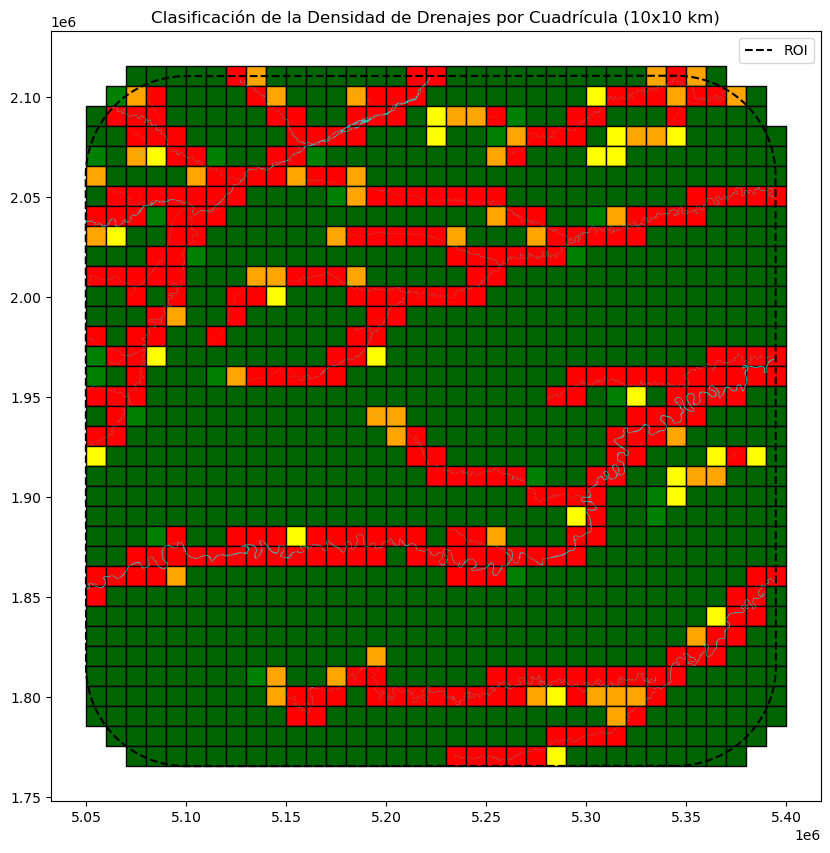

In [30]:
# ---- Definición de la Paleta de Colores ----
# Se asocia cada clase de densidad con un color específico para facilitar la interpretación visual
color_map = {
    4: "darkgreen",  # Menor densidad de drenajes
    3: "green",
    2: "yellow",
    1: "orange",
    0: "red"  # Mayor densidad de drenajes
}

# ---- Creación del Gráfico ----
fig, ax = plt.subplots(figsize=(10, 10))

# Se aplica la paleta de colores definida a la cuadrícula
grid_class.plot(color=grid_class["clase_densidad"].map(color_map), edgecolor="black", ax=ax)

# Se plotean los drenajes en color cian
drenajes_roi.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Drenajes")

# Se dibuja el área del proyecto con un contorno negro
ROI.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="ROI")

# ---- Configuración Final del Gráfico ----
ax.set_title("Clasificación de la Densidad de Drenajes por Cuadrícula (10x10 km)")
ax.legend()
plt.show()

## Asentamientos humanos

Se utiliza como insumo: DIVIPOLA - Códigos cabeceras - Centros poblados https://www.datos.gov.co/Mapas-Nacionales/DIVIPOLA-C-digos-cabeceras-Centros-poblados/xaxy-8nri/about_data

### Asentamientos humanos en el área del proyecto

Para la determinación de la cercanía de los asentamientos humanos se utiliza la metodología propuesta por Molina-González et. al (2018), donde menciona que a los centros poblados se realiza primero un procesamiento de distancia euclidiana y posteriormente una clasificación por intervalos geométricos. Entonces así se logra identificar cual es la categoría que mayor tiene presencia en el área del proyecto.

In [38]:
# ---- Carga de datos ----
# Se carga la capa de asentamientos humanos (Asegurar que la ruta del archivo es correcta)
asentamientos = gpd.read_file("Data/Rangos_CC_Project_area.shp")

# ---- Asegurar consistencia en el sistema de referencia ----
# Se convierte el CRS de la capa de asentamientos al mismo sistema de referencia del área del proyecto
asentamientos = asentamientos.to_crs(project_area.crs)

# ---- Cálculo del área de asentamientos ----
# Se calcula el área de cada polígono de asentamiento en metros cuadrados
asentamientos["area_m2"] = asentamientos.geometry.area

# ---- Sumar área total por categoría ----
# Se agrupa por categoría de asentamiento y se suma el área total
df_area_por_categoria = asentamientos.groupby("gridcode")["area_m2"].sum().reset_index()

# Se convierte el área de metros cuadrados a hectáreas
df_area_por_categoria["area_ha"] = df_area_por_categoria["area_m2"] / 1e4

# Se ordena la tabla de mayor a menor área ocupada
df_area_por_categoria = df_area_por_categoria.sort_values(by="area_ha", ascending=False)

# ---- Mostrar resultados ----
# Se imprime la tabla con las áreas calculadas
print("\n📌 Áreas de las categorías de asentamientos humanos dentro del área del proyecto:")
print(df_area_por_categoria)


📌 Áreas de las categorías de asentamientos humanos dentro del área del proyecto:
   gridcode       area_m2        area_ha
3         4  3.202241e+09  320224.068809
2         3  1.383697e+09  138369.691941
4         5  1.009590e+09  100958.993174
1         2  6.994646e+08   69946.456392
0         1  4.380723e+08   43807.226629


Este script visualiza la distribución de categorías de asentamientos humanos dentro del área del proyecto. Se usa una paleta de colores categórica para diferenciar las categorías de asentamiento y se genera una leyenda personalizada.

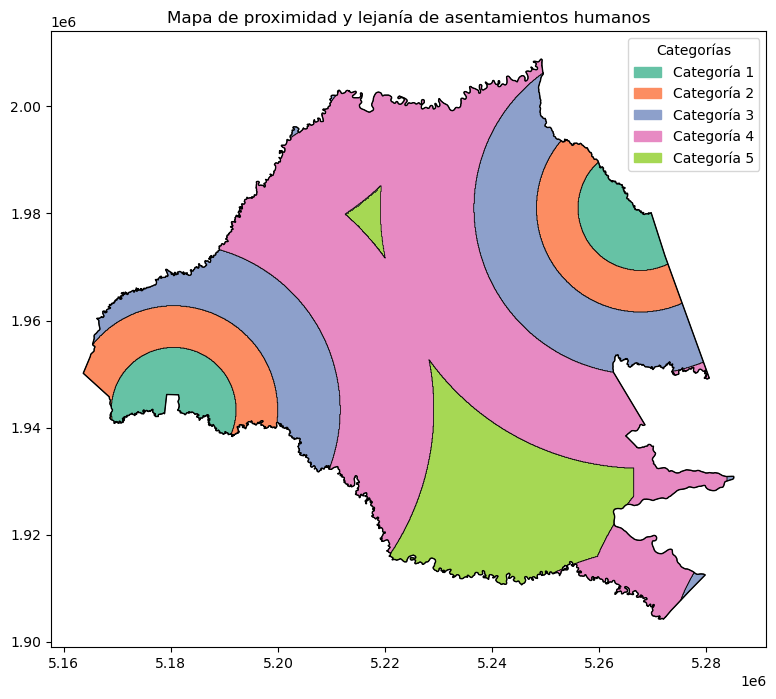

In [43]:
# ---- Asegurar Consistencia en el Sistema de Referencia ----
# Se convierte el CRS de la capa de asentamientos al mismo sistema de referencia del área del proyecto
asentamientos = asentamientos.to_crs(project_area.crs)

# ---- Definición de Paleta de Colores ----
# Se obtienen las categorías únicas y se asigna un color diferente a cada una
unique_categories = sorted(asentamientos["gridcode"].unique())  # Asegurar orden estable
colors = plt.cm.Set2(range(len(unique_categories)))  # Colores diferentes por categoría
cmap = mcolors.ListedColormap(colors)  # Usar solo estos colores
norm = mcolors.BoundaryNorm(unique_categories + [max(unique_categories) + 1], cmap.N)

# ---- Creación del Mapa ----
fig, ax = plt.subplots(figsize=(10, 8))

# Se dibuja el área del proyecto con un contorno negro
project_area.boundary.plot(ax=ax, color="black", linewidth=1, label="Área del Proyecto")

# Se grafican los asentamientos con colores categóricos
asentamientos.plot(column="gridcode", cmap=cmap, norm=norm, ax=ax, edgecolor="black", linewidth=0.5)

# ---- Creación de Leyenda Personalizada ----
handles = [mpatches.Patch(color=cmap(norm(cat)), label=f"Categoría {cat}") for cat in unique_categories]
ax.legend(handles=handles, title="Categorías", loc="upper right")

# ---- Ajuste Final del Gráfico ----
ax.set_title("Mapa de proximidad y lejanía de asentamientos humanos")
plt.show()

### Asentamientos humanos en el ROI

Este script ajusta la clasificación de asentamientos humanos en la región de interés (ROI) con base en la presencia de las mismas clasificaciones dentro del área del proyecto y visualiza la distribución con una paleta de colores representativa.

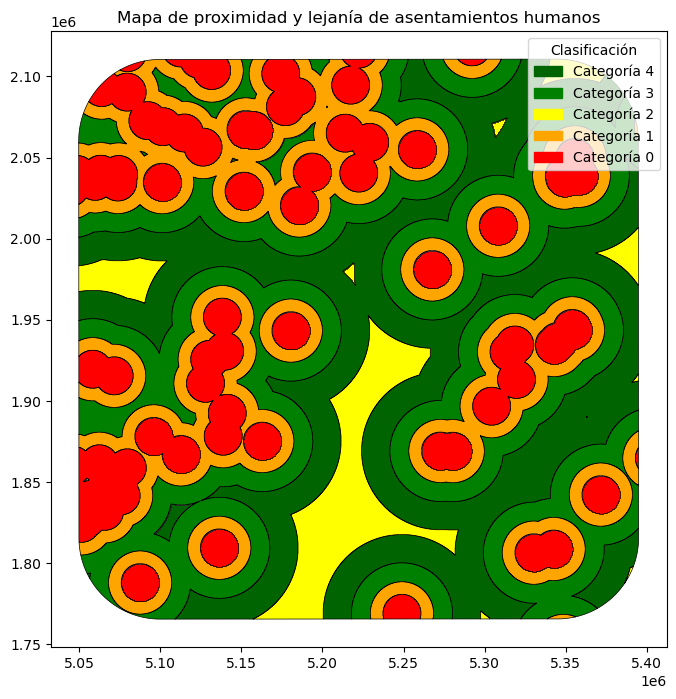

In [45]:
# ---- Carga de Datos ----
# Se carga la capa de asentamientos humanos en la región de interés
asentamientos_roi = gpd.read_file("Data/Rangos_CC_ROI.shp")

# ---- Ajuste de Clasificación ----
# Se reasignan los valores de clasificación en una nueva columna
asentamientos_roi["nueva_clasificacion"] = asentamientos_roi["gridcode"].map({
    4: 4,
    3: 3,
    5: 2,
    2: 1,
    1: 0
})

# ---- Definición de la Paleta de Colores ----
# Se asignan colores a cada categoría de asentamientos
color_map = {
    4: "darkgreen",  # Menor densidad
    3: "green",
    2: "yellow",
    1: "orange",
    0: "red"  # Mayor densidad
}

# ---- Creación del Gráfico ----
fig, ax = plt.subplots(figsize=(10, 8))

# Se grafican los asentamientos por categoría, aplicando la paleta de colores
total_patches = []
for value, color in color_map.items():
    asentamientos_roi[asentamientos_roi["nueva_clasificacion"] == value].plot(
        ax=ax, color=color, edgecolor="black", linewidth=0.5, label=f"Categoría {value}"
    )
    total_patches.append(mpatches.Patch(color=color, label=f"Categoría {value}"))

# ---- Creación de Leyenda Personalizada ----
ax.legend(handles=total_patches, title="Clasificación", loc="upper right")

# ---- Ajuste Final del Gráfico ----
ax.set_title("Mapa de proximidad y lejanía de asentamientos humanos")

# ---- Mostrar el Mapa ----
plt.show()

# Políticas y regulaciones

## Humedales

Se utiliza como insumo: Áreas de importancia especial y ecosistemas estratégicos https://www.colombiaenmapas.gov.co/?e=-91.07859485351392,-7.914089216137852,-57.41648547852286,17.909127410706898,4686&b=igac&u=0&t=2&servicio=1454 

### Humedales en el área del proyecto

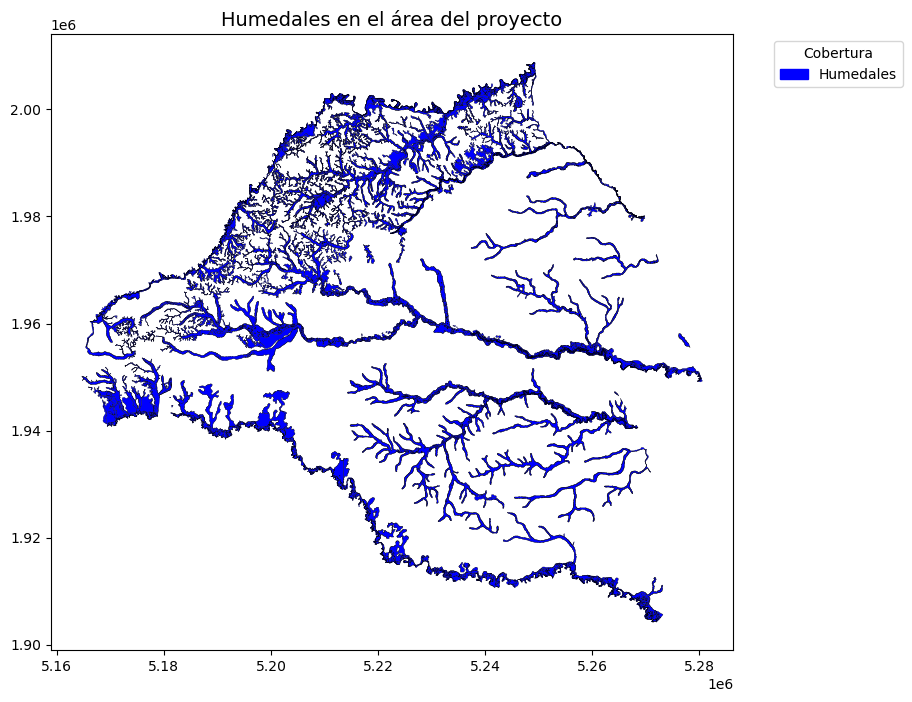

In [19]:
import matplotlib.patches as mpatches

def visualize_wetlands(file_path="Data\\Humedales_project_area.shp"):
    # Cargar la capa geoespacial
    gdf = gpd.read_file(file_path)
    
    # Color único para los humedales
    wetland_color = "blue"
    
    # Crear la visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color=wetland_color, edgecolor='black', linewidth=0.2)
    
    # Agregar leyenda
    legend_patch = [mpatches.Patch(color=wetland_color, label="Humedales")]
    ax.legend(handles=legend_patch, title="Cobertura", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Configuración del mapa
    ax.set_title("Humedales en el área del proyecto", fontsize=14)
    plt.show()

# Uso del script
visualize_wetlands()

### Humedales en el ROI

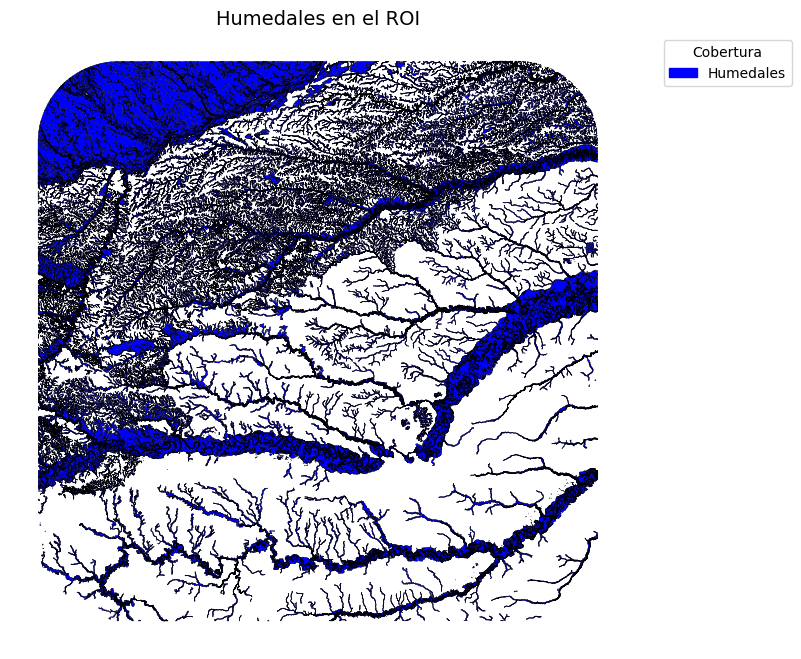

In [20]:
def visualize_wetlands(file_path="Data\\Humedales_ROI.shp"):
    # Cargar la capa geoespacial
    gdf = gpd.read_file(file_path)
    
    # Color único para los humedales
    wetland_color = "blue"
    
    # Crear la visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color=wetland_color, edgecolor='black', linewidth=0.2)
    
    # Agregar leyenda
    legend_patch = [mpatches.Patch(color=wetland_color, label="Humedales")]
    ax.legend(handles=legend_patch, title="Cobertura", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Configuración del mapa
    ax.set_title("Humedales en el ROI", fontsize=14)
    ax.set_axis_off()
    plt.show()

# Uso del script
visualize_wetlands()

# Insumos Raster

##### A continuación se detallan los diferntes insumos raster que seran utilizados junto a un geoprocsamiento inicial 

1. Raster de bosque no bosque de años 2010 y 2020 disponiibles en: https://www.ideam.gov.co/temas/monitoreo-de-bosques/geovisor 
2. DEM de la zona tomado de la plataforma google earth engine: https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4?hl=es-419#description 
3. Mapa de pendientes generado apartir del DEM

Para proceder primero se importan las librerias necesarias para ejecutar los geoproesamientos

In [2]:
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterio.warp
import rasterstats
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pyproj

Inicialmente se toman estos datos para cortarlos con el ROI del proyecto

In [4]:
BNB_2010=rasterio.open("Data/SBQ_SMBYC_BQNBQ_V5_2010.tif") ##Procora ajustar la ruta de acuerdo a donde se ubique cada archivo
BNB_2020=rasterio.open("Data/SBQ_SMBYC_BQNBQ_V5_2020.tif")
DEM=rasterio.open("Data/SRTM_V4.tif")
roi=gpd.read_file("Data/ROI_2_P.shp")

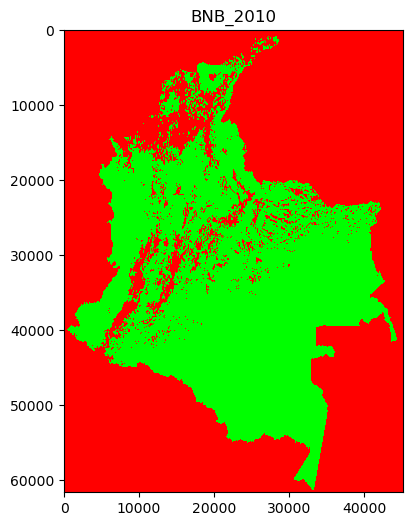

In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.colors as mcolors

# Cargar el raster
ruta_raster = "Data/SBQ_SMBYC_BQNBQ_V5_2010.tif"

with rasterio.open(ruta_raster) as src:
    raster = src.read(1)  # Leer la primera banda
    profile = src.profile  # Obtener metadatos del raster

# Definir una colormap categórica (ejemplo con 5 clases)
cmap = mcolors.ListedColormap(["#00ff00","#ff0000"])
bounds = [1, 2]  # Valores de las clases
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Visualizar el raster
plt.figure(figsize=(8, 6))
plt.imshow(raster, cmap=cmap, norm=norm)
plt.title("BNB_2010")
plt.show()

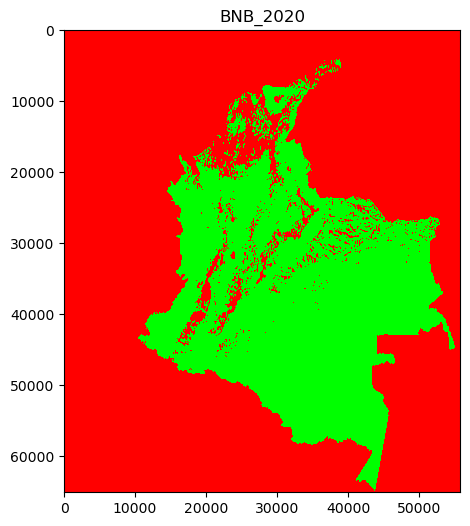

In [7]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.colors as mcolors

# Cargar el raster
ruta_raster = "Data/SBQ_SMBYC_BQNBQ_V5_2020.tif"

with rasterio.open(ruta_raster) as src:
    raster = src.read(1)  # Leer la primera banda
    profile = src.profile  # Obtener metadatos del raster

# Definir una colormap categórica (ejemplo con 5 clases)
cmap = mcolors.ListedColormap(["#00ff00","#ff0000"])
bounds = [1, 2]  # Valores de las clases
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Visualizar el raster
plt.figure(figsize=(8, 6))
plt.imshow(raster, cmap=cmap, norm=norm)
plt.title("BNB_2020")
plt.show()

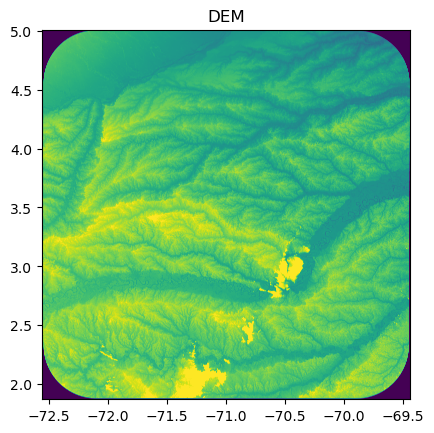

<Axes: title={'center': 'DEM'}>

In [9]:
plt.title("DEM")
rasterio.plot.show(DEM)

Luego de lo anterior se validan las proyecciones para poder hacer el recorte

In [10]:
print("Para el  raster 2010",BNB_2010.crs)
print("Para el  raster 2020",BNB_2020.crs)
print("Para el  raster DEM",DEM.crs)
print("Para el  roi ",roi.crs)

Para el  raster 2010 GEOGCS["GCS_MAGNA",DATUM["MAGNA",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Para el  raster 2020 GEOGCS["GCS_MAGNA",DATUM["D_MAGNA",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Para el  raster DEM GEOGCS["GCS_MAGNA",DATUM["D_MAGNA",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Para el  roi  EPSG:4686


Luego de haber confirmado que todos los raster y el ROI tienen la mismas proyección se procede a hacer el recorte 

In [11]:
import rasterio.mask

# Recorte del raster 2010 con el ROI
out_image_mask1, out_transform_mask1 = rasterio.mask.mask(
    BNB_2010,
    roi.geometry,  # Asegúrate de que roi.geometry es válido y está alineado con el CRS del raster
    crop=True
)
print("Recorte 2010 completado.")

# Recorte del raster 2020 con el ROI
out_image_mask2, out_transform_mask2 = rasterio.mask.mask(
    BNB_2020,
    roi.geometry,  # Asegúrate de que roi.geometry es válido y está alineado con el CRS del raster
    crop=True
)
print("Recorte 2020 completado.")

# Recorte del DEM con el ROI
out_image_mask3, out_transform_mask3 = rasterio.mask.mask(
    DEM,
    roi.geometry,  # Asegúrate de que roi.geometry es válido y está alineado con el CRS del raster
    crop=True
)
print("Recorte DEM completado.")

Recorte 2010 completado.
Recorte 2020 completado.
Recorte DEM completado.


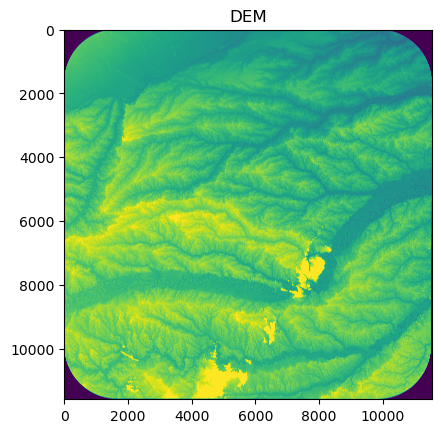

<Axes: title={'center': 'DEM'}>

In [12]:
# Visualización del raster recortado.

plt.title("DEM")
rasterio.plot.show(out_image_mask3)

Con lo anterior, se procede a crear el mapa de pendiente y asi pbtener todos los insumos necesarios a nivel raster

In [13]:
#Mapa de pendiente 

import os

In [14]:
os.system('gdaldem slope Data/SRTM_V4.tif Data/SRTM_SLOPE.tif')

0

In [15]:
path_in ="Data/SRTM_V4.tif"
slope_out = "Data/SRTM_SLOPE.tif"
comando = f'gdaldem slope "{path_in}" "{slope_out}"'
os.system(comando)

0

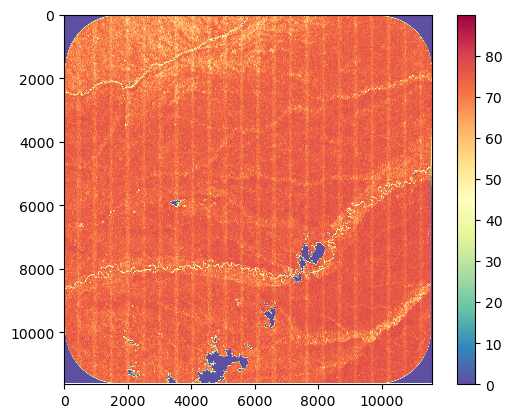

In [16]:
# Pendiente
src_srtm_slope = rasterio.open(slope_out)
srtm_slope = src_srtm_slope.read(1)
srtm_slope[srtm_slope == src_srtm_slope.nodata] = np.nan
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm_slope, cmap='Spectral_r', ax=ax)
fig.colorbar(ax.imshow(srtm_slope, cmap='Spectral_r'), ax=ax);